<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Preprocessing-and-Data-Loading" data-toc-modified-id="Preprocessing-and-Data-Loading-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocessing and Data Loading</a></span><ul class="toc-item"><li><span><a href="#Import-necessary-modules" data-toc-modified-id="Import-necessary-modules-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Import necessary modules</a></span></li><li><span><a href="#Some-Comments-on-Preprocessing" data-toc-modified-id="Some-Comments-on-Preprocessing-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Some Comments on Preprocessing</a></span></li><li><span><a href="#Loading-the-Data-via-Pytorch-DataLoader" data-toc-modified-id="Loading-the-Data-via-Pytorch-DataLoader-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Loading the Data via Pytorch DataLoader</a></span></li></ul></li><li><span><a href="#Build-the-Model" data-toc-modified-id="Build-the-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build the Model</a></span></li><li><span><a href="#Train-and-Test" data-toc-modified-id="Train-and-Test-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train and Test</a></span></li><li><span><a href="#Post-Processing" data-toc-modified-id="Post-Processing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Post-Processing</a></span><ul class="toc-item"><li><span><a href="#Display-The-Predictions-with-Ground-Truths" data-toc-modified-id="Display-The-Predictions-with-Ground-Truths-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Display The Predictions with Ground Truths</a></span></li><li><span><a href="#Evaluate-the-Performance-Metrics" data-toc-modified-id="Evaluate-the-Performance-Metrics-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Evaluate the Performance Metrics</a></span><ul class="toc-item"><li><span><a href="#Confusion-Matrix" data-toc-modified-id="Confusion-Matrix-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Confusion Matrix</a></span></li><li><span><a href="#Overall-Accuracy" data-toc-modified-id="Overall-Accuracy-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Overall Accuracy</a></span></li><li><span><a href="#Recall" data-toc-modified-id="Recall-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>Recall</a></span></li><li><span><a href="#Precision" data-toc-modified-id="Precision-5.2.4"><span class="toc-item-num">5.2.4&nbsp;&nbsp;</span>Precision</a></span></li><li><span><a href="#F1-Score" data-toc-modified-id="F1-Score-5.2.5"><span class="toc-item-num">5.2.5&nbsp;&nbsp;</span>F1-Score</a></span></li></ul></li></ul></li></ul></div>

## Introduction

- In these series of notebooks, we will explore how to create an image recognition model from scratch in Pytorch. 
- Part-1 and Part-2 concerns fully connected neural network(FNN) and convolutional neural network(CNN) models. In Part-3, we will discuss transfer learning concept.
- This first notebook will be the backbone of our analysis. We will gradually improve our model, notebook functions as well as the way we interpret the problem in consideration.
- We will be working on House_Room dataset [here](https://www.kaggle.com/robinreni/house-rooms-image-dataset). Ultimate goal is to create a neural network model which can recognize the room types with high level of confidence.
- The number of new concepts and the level of difficulty can be overwhelming. Thus, just focus on the general concepts rather than tedious programming tasks. Here we go:

## Preprocessing and Data Loading

### Import necessary modules

In [1]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

    #import modules here if necessary
    !pip install torchinfo

    #make-dirs
    !mkdir -p '/content/House_Rooms_Dataset/train'
    !mkdir -p '/content/House_Rooms_Dataset/test'
    !mkdir -p '/content/results/House_Rooms'
    
    #define test-train-ext dirs
    train_dir = '/content/House_Rooms_Dataset/train'
    test_dir = '/content/House_Rooms_Dataset/test'
    ext_dir = '/content/results/House_Rooms'

    #modify here
    !unzip -u '/content/drive/MyDrive/ColabNotebooks/SpelmanResearch/datasets/House_Rooms_Resized/train.zip' -d '/content/House_Rooms_Dataset'
    !unzip -u '/content/drive/MyDrive/ColabNotebooks/SpelmanResearch/datasets/House_Rooms_Resized/test.zip' -d '/content/House_Rooms_Dataset'
else:
    #change this to your own local directories if you dont work on Colab
    train_dir = 'datasets/House_Room_Dataset_Resized/train/'
    test_dir = 'datasets/House_Room_Dataset_Resized/test/'
    ext_dir =  'results/House_Rooms/'

In [2]:
#==============================#
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
#===========================#
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
#============================#
import copy
import os
import random
import sys
from torchinfo import summary
from sklearn.metrics import confusion_matrix
from collections import Counter
import warnings
warnings.filterwarnings('ignore') 
#==============================#
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA GeForce RTX 2070 Super


### Some Comments on Preprocessing 

-  We will be working on House_Room dataset [here](https://www.kaggle.com/robinreni/house-rooms-image-dataset). Task is to classify five room types of houses. 
-  Original dataset has around 5000 images of size 224x224 RGB and does not have train-test folders. It is composed of just root directory and class folders in it. We would like to create subset of it.
- Perform train-test split via *CreateTrainTest*. This function will scan the images in each class, mark as training and testing and copy them 'train' and 'test' folders in the same directory.
- Resize all the images to 60x60 via *ResizeSave*. In order to speep-up the training, resizing was performed before training, not as part of augmentation. This step is usually overlooked in many application. However, resizing is a big bottlenect significantly increasing the training time.  

-  After these steps, we have a folder called 'House_Room_Dataset_Resized'. This will be our root directory from now on. Let's keep these functions in a seperate directory python file "HelperFunctions.py". We can import and use them whenever we want.

### Loading the Data via Pytorch DataLoader

- Pytorch provides several classes which make the data loading easy and fast.
- It is essential to perform data augmentation on the training data. Core idea is to feed different batch of modified images to the model. Please carefully read the section 'Improving Neural Networks' in the report in our repository. 
- We have just one data augmentation here which is to 'Shuffle' the images in each batch. In the second part of this notebook, we will introduce more augmentation with convolutional neural networks.Thus, consider this part as the experimental stage.

In [3]:
#reading and loading the data
training_transforms = transforms.Compose([transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.ToTensor()])


train_set = datasets.ImageFolder(train_dir, transform = training_transforms)
test_set  = datasets.ImageFolder(test_dir, transform = test_transforms)

batch_size = 10
train_loader = DataLoader(train_set,batch_size = batch_size,drop_last=True,shuffle=True)
test_loader = DataLoader(test_set,batch_size = batch_size)

In [4]:
class_list = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx
print(class_to_idx)

idx_to_class = {i:j for i, j in enumerate(class_list)}
num_classes = len(class_list)
dis_dict = dict(Counter(train_loader.dataset.targets))
class_counts = list(dis_dict.values())

print(class_counts)

{'Bathroom': 0, 'Bedroom': 1, 'Dinning': 2, 'Kitchen': 3, 'Livingroom': 4}
[484, 998, 926, 772, 1018]


The following output is important. Since we set batch_size = 10, we have 10 images in each 'load' and 10 labels corresponding to each of these images.

In [5]:
images, labels = iter(train_loader).next()
print(images.shape)
print(labels)

torch.Size([10, 3, 60, 60])
tensor([1, 2, 0, 3, 1, 2, 1, 2, 4, 4])


In [6]:
#80%-20%
print(f'train_set has {len(train_set)} images')
print(f'testing_set has {len(test_set)} images')

train_set has 4198 images
testing_set has 1052 images


In [7]:
def GetDataPaths(train_dir,test_dir):
    train_image_paths = []
    test_image_paths = []
    for (dirpath, dirnames, filenames) in os.walk(train_dir):
        for names in filenames:
            train_image_paths.append(os.path.join(dirpath,names))
    for (dirpath, dirnames, filenames) in os.walk(test_dir):
        for names in filenames:
            test_image_paths.append(os.path.join(dirpath,names))

    random.shuffle(train_image_paths)
    random.shuffle(test_image_paths)
    
    return train_image_paths,test_image_paths

train_image_paths,test_image_paths = GetDataPaths(train_dir, test_dir)

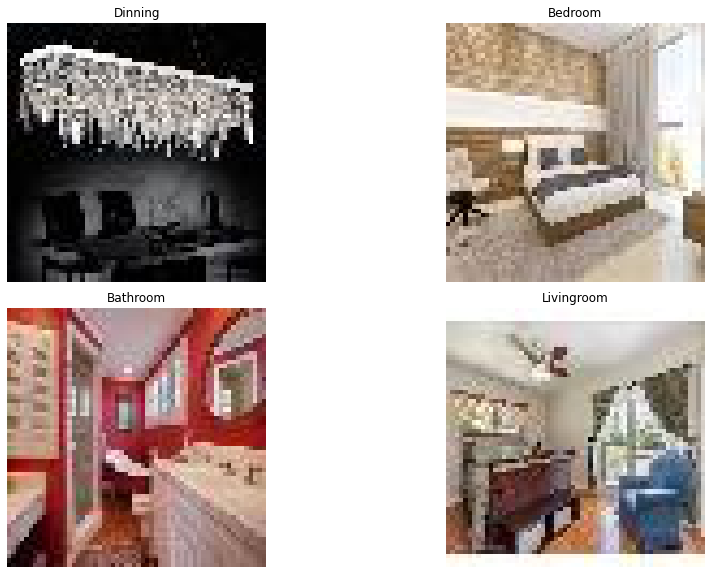

In [8]:
#let's look at some images on nxn grid
def ViewSamples(n,img_paths):
    plt.figure(figsize=(15, 10))
    img_lst = random.sample(img_paths,n*n)
    for i,img_path in enumerate(img_lst):
        img = Image.open(img_path).convert('RGB')
        label  = img_path.split('/')[-2]
        plt.subplot(n, n, i+1) 
        plt.subplots_adjust(hspace=0.1,wspace=0.1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    
ViewSamples(2,train_image_paths)

- A common practice is to check the class distributions. It is important to have almost the same number of images from each class type. Otherwise, the model will struggle to learn the minority class, in this case 'Kitchen'
- There are very well established methods(oversampling, use class weights etc) to deal with this issue but we will reserve them for another lecture.

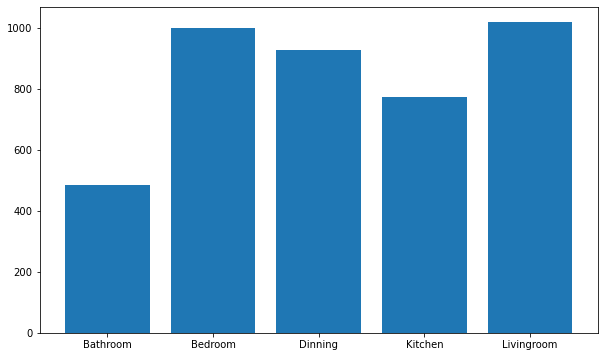

In [9]:
#If we just use the original data, this is quite skew... Later..
def ShowClassDist(name='classDist'):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(class_list, class_counts)
    plt.xticks(fontsize=10, rotation=0)
    plt.show()
ShowClassDist()

## Build the Model 

As the first step, let's build a fully connected network with 3 hidden layers having 100,50,20 neurons, respectively.

In [10]:
# Extent nn.Module to create a custom FCN
class HouseModel(nn.Module):
    def __init__(self):
        super(HouseModel,self).__init__()
        
        self.fc1 = nn.Linear(3*60*60, 100)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(100, 50)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(50, 20)
        self.relu3 = nn.ReLU()
        
        self.out = nn.Linear(20, num_classes)
            
    def forward(self, t):

        t = torch.flatten(t,1)
        t = self.relu1(self.fc1(t))
        t = self.relu2(self.fc2(t))
        t = self.relu3(self.fc3(t))
                
        t = self.out(t)
        
        return t

In [11]:
model = HouseModel()

In [12]:
summary(model,input_size=(batch_size,3,60,60))

Layer (type:depth-idx)                   Output Shape              Param #
HouseModel                               --                        --
├─Linear: 1-1                            [10, 100]                 1,080,100
├─ReLU: 1-2                              [10, 100]                 --
├─Linear: 1-3                            [10, 50]                  5,050
├─ReLU: 1-4                              [10, 50]                  --
├─Linear: 1-5                            [10, 20]                  1,020
├─ReLU: 1-6                              [10, 20]                  --
├─Linear: 1-7                            [10, 5]                   105
Total params: 1,086,275
Trainable params: 1,086,275
Non-trainable params: 0
Total mult-adds (M): 10.86
Input size (MB): 0.43
Forward/backward pass size (MB): 0.01
Params size (MB): 4.35
Estimated Total Size (MB): 4.79

Recall that forward pass works like 
\begin{equation*}
z^{i} = \mathbf{W}^{i}a^{i-1}+b^{i} \\
a^{i} = \sigma(z^{i})
\end{equation*}

where $i=1.2... L$ and $\sigma$ is the predefined activation function. Dimension of the weight matrix $\mathbf{W}^{i}$ is $MxN$ where
M is the number of neurons in the $(i+1)$th layer and N is the number of neurons in the $i$th layer. The bias $b$ is $Nx1$.


In [13]:
#carefully examine what we have here
print(f'W_1: {model.fc1.weight.shape}    b_1: {model.fc1.bias.shape} ')
print(f'W_2: {model.fc2.weight.shape}    b_2: {model.fc2.bias.shape} ')
print(f'W_3: {model.fc3.weight.shape}    b_3: {model.fc3.bias.shape} ')
print(f'W_4: {model.out.weight.shape}    b_4: {model.out.bias.shape} ')

W_1: torch.Size([100, 10800])    b_1: torch.Size([100]) 
W_2: torch.Size([50, 100])    b_2: torch.Size([50]) 
W_3: torch.Size([20, 50])    b_3: torch.Size([20]) 
W_4: torch.Size([5, 20])    b_4: torch.Size([5]) 


In [14]:
#let's take a batch from dataloader and interpreate the output
model  = HouseModel()
imgs,labels = iter(train_loader).next()
outputs = model(imgs)
print(f'labels\n {labels}')
print(f'outputs\n {outputs}')

labels
 tensor([2, 4, 2, 4, 2, 2, 2, 2, 1, 2])
outputs
 tensor([[ 0.0446, -0.0239, -0.0109, -0.0423,  0.0792],
        [ 0.0426, -0.0284, -0.0180, -0.0493,  0.0900],
        [ 0.0255, -0.0272, -0.0194, -0.0348,  0.0907],
        [ 0.0305, -0.0355, -0.0228, -0.0613,  0.0957],
        [ 0.0257, -0.0421, -0.0165, -0.0550,  0.0872],
        [ 0.0183, -0.0384, -0.0248, -0.0384,  0.0908],
        [ 0.0355, -0.0281, -0.0200, -0.0485,  0.0785],
        [ 0.0256, -0.0363, -0.0023, -0.0314,  0.0998],
        [ 0.0383, -0.0287, -0.0167, -0.0469,  0.0902],
        [ 0.0315, -0.0304, -0.0164, -0.0334,  0.0863]],
       grad_fn=<AddmmBackward0>)


## Train and Test


- In a typical supervised learning task, we have training and testing functions. We then call this functions in order to monitor the progress of our model. More precisely, train and test the model in each epoch.
- It is always a good practice to save the 'best performing model'. This means, we will keep track of the 'best accuracy' in each epoch and save the model achieving that best accuracy. This is important because we can then load this model and start training from where we left off. We will use SaveModel and LoadModel functions for this purpose.
- It is not reasonable to expect a good performance from a fully connected neural network on RGB images. Moreover, we will not spend any time to improve the model. Thus, just focus on the concepts for now. We will discuss about potential improvement techniques in the later sections such as **"hyperparameter optimization", "data augmentation"**.


In [15]:
def TrainHouseModel(model, train_loader, optimizer):
   
    # set to train mode
    model.train()
    
    #send to cuda/GPU
    model.to(device)
    
    #loss function
    criterion = nn.CrossEntropyLoss()

    # compute the train loss and correct predictions per epoch
    train_loss = 0.0
    total_train_correct = 0
    
    
    for i,(images, labels) in enumerate(train_loader):
        #clear the cuda cache
        torch.cuda.empty_cache()
        
        #send to cuda
        images = images.to(device)
        labels = labels.to(device)
        
        # FORWARD PASS
        #compute the prediction for the batch
        outputs = model(images)

        # compute the loss
        loss = criterion(outputs, labels)

        
        #BACK-PROPOGATION
        # compute the gradient
        loss.backward()

        # update the weights and biases/ gradient decent
        optimizer.step()

        #GET SOME METRICS
        # compute the total loss for the batch and add it to train_loss
        train_loss += loss.item() * images.size(0)

        # compute the predictions for each class
        predictions = outputs.argmax(dim=1)

        # boolen compare the predictions vs targets and create the correct count tensor
        correct_counts = predictions.eq(labels)
        
        # accumulate the total test correct and update over the batches.
        total_train_correct += correct_counts.sum().item()

        #zero out before each backpropagation.
        optimizer.zero_grad()

    # training loss and training accuracy for the epoch/one complete cycle
    train_loss = train_loss/len(train_loader.dataset) 
    train_acc = total_train_correct/float(len(train_loader.dataset))
    
    
    return train_acc, train_loss

In [16]:
def TestHouseModel(model, test_loader):
    # For testing, no need to track gradients. 
    model.eval()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.
    total_test_correct = 0
    with torch.no_grad():
        for j,(images, labels) in enumerate(test_loader):
            torch.cuda.empty_cache()
            images = images.to(device)
            labels = labels.to(device)

            # FORWARD PASS
            outputs = model(images)

            # compute the loss
            loss = criterion(outputs, labels)

            #GET SOME METRICS
            # compute the loss for the batch and add it to total test_loss
            test_loss += loss.item() * images.size(0)

            # compute the predictions
            predictions = outputs.argmax(dim=1)

            # boolen compare the predictions vs labels and create the correct count tensor
            correct_counts = predictions.eq(labels)

            # accumulate the total test correct and update over the batches.
            total_test_correct += correct_counts.sum().item()

    # test loss and test accuracy for the epoch/one complete cycle
    
    test_loss = test_loss/len(test_loader.dataset) 
    test_acc = total_test_correct/float(len(test_loader.dataset))


    return test_acc, test_loss

In [17]:
def SaveModel(name,checkpoint):
    path = f'{ext_dir}/{name}.pth'
    torch.save(checkpoint, path )

def LoadModel(model,filepath):
    #add optimizer for retraining.
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    model.best_scores = checkpoint['best_stats']
    model.eval()
    
    return model

This is the driver function to train our model. There are couple of things we should pay attention
- We train the model on training set get accuracy and loss and then immediately test the accuracy and loss on testing data. We are mostly interested in the second part. Even though, the loss is going down and the accuracy is going up(even 99%) on training data, the model is useless unless it equally performs on *testing* data as well.
- For example, the following situation is a perfect example of 'overfitting'. The model memorizes the training set but fails to generalize to unseen testing data. Notice how the loss in training set is going down but going up in the testing set.
- Again, there are tons of things we can do to remedy this issue but let's learn the necessary tools for now.

In [18]:
def StartTraining(model,lr,num_epochs,log_int):    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    max_acc = 0.
    train_loss_list = []
    test_loss_list = []
    best_state_dic = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs+1):
        train_acc, train_loss =TrainHouseModel(model, train_loader, optimizer)
        test_acc, test_loss = TestHouseModel(model,test_loader)
        
        if epoch%log_int==0:    
            print(f'epoch:{epoch} train_acc:{train_acc:0.2f} test_acc: {test_acc:0.2f} ')

        if test_acc > max_acc:
            max_acc = test_acc
            best_state_dic = copy.deepcopy(model.state_dict())
            
            beststats = {'BestTestAcc':     max_acc ,  
                         'lr':              lr,
                        'batch_size':       batch_size,
                        }
            checkpoint = { 'state_dict':  best_state_dic ,
                       'best_stats':  beststats
                     }

            SaveModel('HouseModelFNN',checkpoint)
            
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
    
    return train_loss_list,test_loss_list

In [19]:
train_loss_list,test_loss_list =  StartTraining(model = HouseModel(),lr = 1e-4,num_epochs = 30,log_int=10)

epoch:0 train_acc:0.25 test_acc: 0.26 
epoch:10 train_acc:0.36 test_acc: 0.32 
epoch:20 train_acc:0.40 test_acc: 0.33 
epoch:30 train_acc:0.46 test_acc: 0.33 


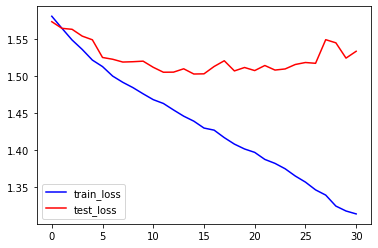

In [20]:
#what we see here is called "overfitting".
num_epochs = 31
eps = np.linspace(0,num_epochs-1,num_epochs)
plt.plot(eps,train_loss_list,'b-',eps,test_loss_list,'r-')
plt.legend(['train_loss','test_loss'])
plt.show()

## Post-Processing

First let's load the saved model and use it to evaluate our model performance

In [21]:
#this will reload the model with 'learned parameters'
model = LoadModel(HouseModel(),'results/House_Rooms/HouseModelFNN.pth')
model.best_scores

{'BestTestAcc': 0.3403041825095057, 'lr': 0.0001, 'batch_size': 10}

### Display The Predictions with Ground Truths

In [22]:
@torch.no_grad()
def GetClassProbs(model,image_path, topk=3):
    model.to(device)
    model.eval()
    img = Image.open(image_path).convert("RGB")
    label = image_path.split('/')[-2]
    img = test_transforms(img)
    img = img.unsqueeze(0).to(device)
    output = model(img)
    #get probabilities
    probs = F.softmax(output) 
    top_probabilities, top_indices = probs.topk(topk)
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0]
    top_probabilities = [ round(elem, 2) for elem in top_probabilities ]
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes

In [23]:
def ShowPredictions(n):
    plt.subplots(n,2,figsize=(12, 4*n)) 
    plt.subplots_adjust(0,0,3,3,wspace = 0.5)
    for i in range(1,n+1):
        rnd_number = random.randint(0,len(test_image_paths))
        img_path = test_image_paths[rnd_number]
        label = img_path.split('/')[-2]
        image = Image.open(img_path).convert("RGB")
        plt.subplot(n,2,2*i-1)
        plt.title(label)
        plt.imshow(image)
        probs, classes = GetClassProbs(model,img_path, topk=3)
        plt.subplot(n,2,2*i)
        plt.barh(classes, probs,align='center',color='orange') 
        for index, value in enumerate(probs):
            plt.text(value, index,str(value),color='red')
        plt.tight_layout()
    plt.show()

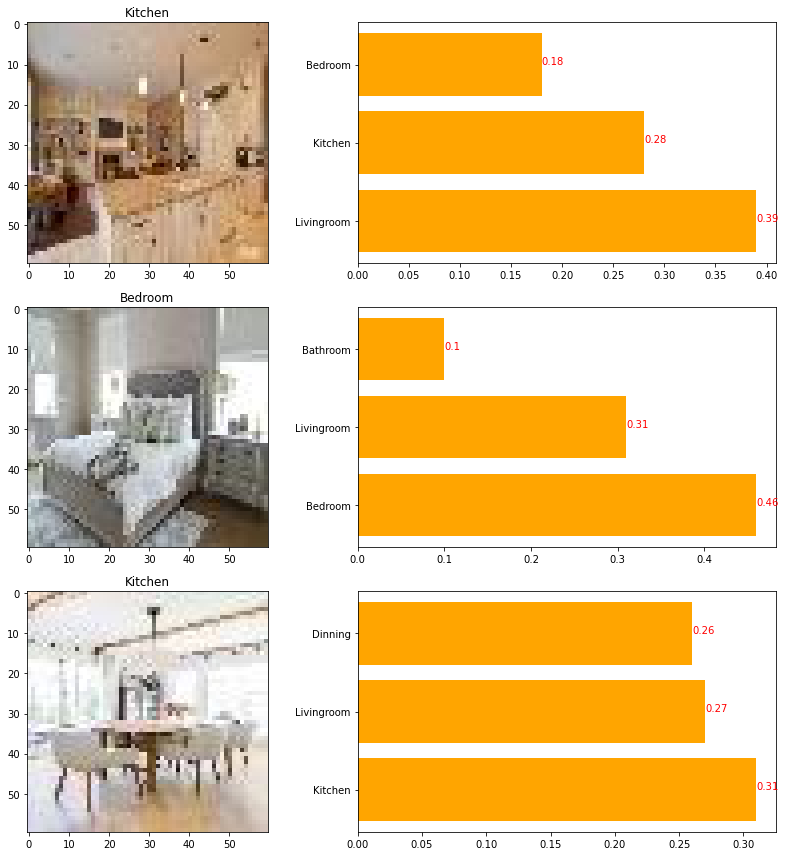

In [24]:
ShowPredictions(3)

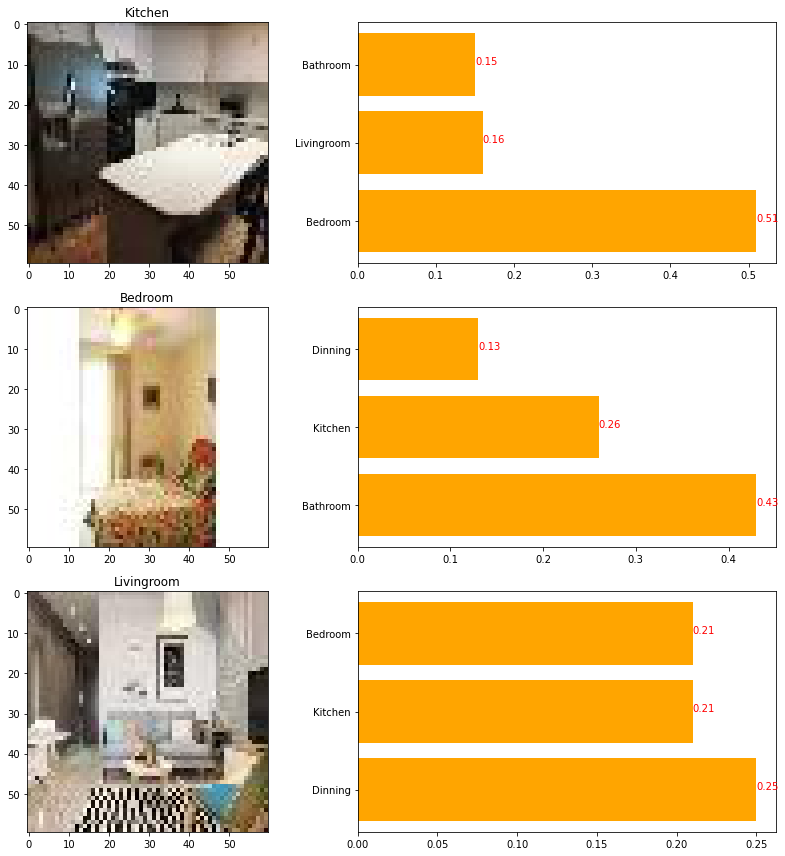

In [25]:
ShowPredictions(3)

### Evaluate the Performance Metrics

- For more details, consult to our lecture notes resources folder in this repo

#### Confusion Matrix

- The most important outcome of a classification problem is the confusion matrix. Each **row** of the matrix represents the instances **actual class** while each **column** represents the instances in a **predicted class**. 
-  Confusion matrix allows us to determine all the necessary metrics to evaluate the performance of an image classification model. First of all, let's see how we interpret confusion matrix for a simple scenario.

In [26]:
def GetConfusionMatrix(model, test_loader):
    with torch.no_grad():
        model.eval()
        model.to(device)
        all_preds  = torch.FloatTensor([]).to(device)
        all_labels = torch.LongTensor([]).to(device)
        #compute all predictions
        for images, labels in iter(test_loader):
            images,labels = images.to(device),labels.to(device)
            preds = model(images)
            all_preds = torch.cat(
                (all_preds,preds),
                dim=0
            )
            all_labels = torch.cat((all_labels,labels),dim=0)
        
        #get the predicted labels
        preds = all_preds.argmax(dim=1)
        #create confusion matrix
        cm = confusion_matrix(all_labels.cpu().numpy(), preds.cpu().numpy())
        return cm
cm = GetConfusionMatrix(model,test_loader)

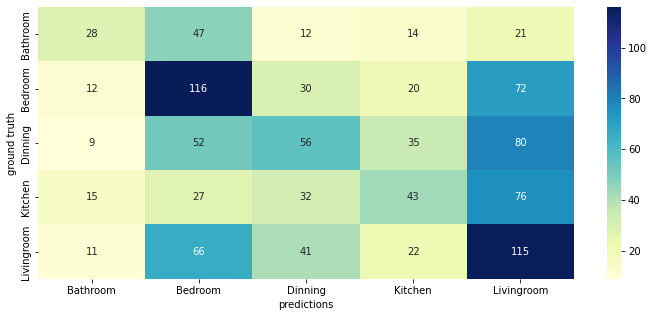

In [27]:
#display confusion matrix. truth:x_axis(rows), preds:y_axis(cols)
df_cm = pd.DataFrame(cm, index = [i for i in class_list], columns = [i for i in class_list])
plt.figure(figsize=(12,5))
sns.heatmap(df_cm,annot=True,cmap="YlGnBu",fmt='g')
plt.xlabel('predictions')
plt.ylabel('ground truth')
plt.show()

- Rows are the ground-truths and the coloumsn are are predictions
- For example, first row tells us, there are 122 'Bathroom' images in the testset and 21 are predicted as 'Bathroom', 31 as 'Bedroom', 21 as Dining, 22 as 'Kitchen', 27 'Livingroom.
- This matrix includes the following;
\begin{bmatrix}
\text{  TruePositives} & \text{FalseNegatives}  \\
\text{FalsePositives}  & \text{TrueNegatives}  
\end{bmatrix}
- Important formulas we will discuss are the followings;

$$\text{Overall Accuracy} =  \dfrac{TP+TN}{TP+TN+FP+FN}$$

$$\text{Recall} = \dfrac{TP}{TP+FN}$$

$$\text{Precision} = \dfrac{TP}{TP+FP}$$

$$\text{F1-Score} = \dfrac{1}{\frac{1}{Recall}+\frac{1}{Precision}}$$

- For more info, please read the Wikipedia article [here](https://en.wikipedia.org/wiki/Confusion_matrix) about the confusion matrix.

#### Overall Accuracy

Overal accuracy is important but it should be taken in caution as a high overal accuracy can be misleading.

In [28]:
#add text on top of barplot
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center',color='magenta')

def DisplayScores(class_list,scores,score_type = ''):
    fig, ax = plt.subplots(figsize=(9,4))
    ax.bar(class_list, scores,color='orange')
    ax.set_xticklabels(class_list, rotation=0)
    title = 'mean_' + score_type +':'+ str(np.round(scores.mean(),2))
    ax.set_title(title,color='magenta')
    addlabels(class_list,scores)
    plt.savefig(f'{ext_dir}/{score_type}.png')
    plt.show()

In [29]:
#returns major matrics
def GetScores(cm,score_type):
  accuracy = np.around(np.sum(np.diag(cm))/np.sum(cm),2)
  recalls = np.around(np.diag(cm)/np.sum(cm,axis = 1),2)
  precisions = np.around(np.diag(cm)/np.sum(cm,axis = 0),2)
  f1 = np.around( 2/(1/recalls + 1/precisions),2)
  if score_type=='accuracy':
    return accuracy
  if score_type=='recalls':
    return recalls
  if score_type=='precisions':
    return precisions
  if score_type=='F1':
    return f1
  else:
    print('Enter one of the score types \n accuracy,recalls,precisions or F1 ')

In [30]:
# Be cautius, not always the best way
OveralAcc = GetScores(cm,score_type = 'accuracy')
print('OverallAccuracy', OveralAcc)

OverallAccuracy 0.34


#### Recall

- Recall tells us the ability of algoritm to classify a particular class. 
- For example, first row tells us, there are 122 'Bathroom' images in the testset and 21 are predicted as 'Bathroom' This means 21 out of 122 is correct. Thus the recall is 21/122 = 0.17 for Bathroom'.
- Remember **recall is truth-based**. 17% recall for Bathroom means "out of 100 Bathroom images, we are capable of getting only 17 right "...

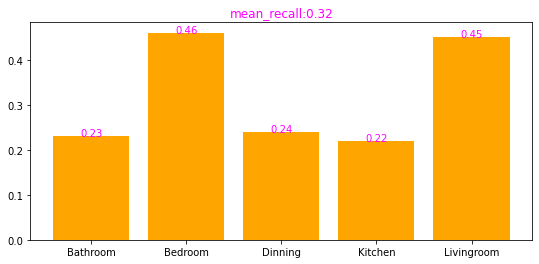

In [31]:
recalls = GetScores(cm,score_type = 'recalls')
DisplayScores(class_list,recalls,'recall')

#### Precision

- Precision for a class tells us the ability of an alg **not to label anything as that class**. 
- First coloumn tells us 51 images are classified as 'Bathroom' and only 21 is correct. Thus precision for 'Bathroom' is 21/51 = 41%, very low.
- Remember, **precision is prediction based**. Thus, 41% precision means, out of 100 Bathroom predictions, only 41 is correct. 

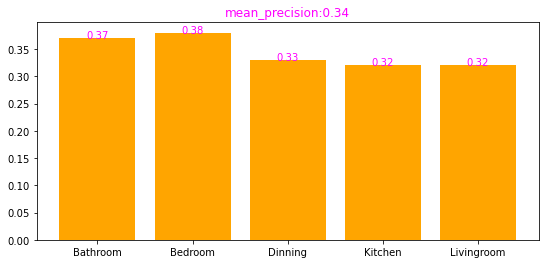

In [32]:
precisions = GetScores(cm,score_type = 'precisions')
DisplayScores(class_list,precisions,'precision')

#### F1-Score

This is the harmonic average of recall recall and precision. It is a realiable measure putting equal weigths on precison and recall. It sits somewhere between precision and recall. 

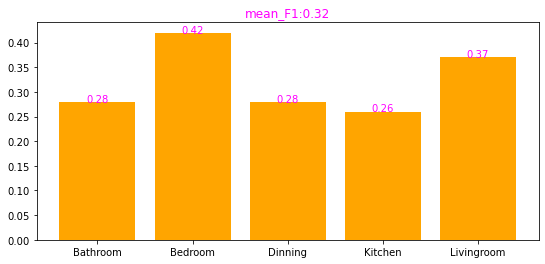

In [33]:
F1 = GetScores(cm,score_type='F1')
DisplayScores(class_list,F1,'F1')